In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy
import ase.io as aio
import scipy.io as sio
import glob
from toolz.curried import pipe, curry

In [3]:
from ase.neighborlist import neighbor_list

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.color'] = 'r'
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

In [5]:
from ase import Atoms
import numpy.fft as mf

In [6]:
def epanechnikov(u, h):
    p = 0.75*(5**(-0.5))*(1 - (u**2)/(5*h**2))/h
    p[p<0] = 0
    return p


def mk_kernel(width, x):
    steps = x[1:] - x[:-1]
    width = width/np.sqrt(5)

    if not np.all(np.isclose(steps[0], steps)):
        raise ValueError('Bins need to be same width!')
        return None

    k_half = int((np.sqrt(5)*width)//steps[0] + 1)
    u = np.linspace(-k_half*steps[0],k_half*steps[0],k_half*2+1)

    kernel = epanechnikov(u=u, h=width)
    shift_to_mid = -len(kernel)//2 + 1
    kernel_arr = np.zeros(len(x))
    kernel_arr[:len(kernel)] = kernel
    kernel_arr = np.roll(kernel_arr, shift_to_mid)
    return kernel_arr


def conv_kernel(kern_arr, p):
    h1 = mf.fftn(kern_arr)
    h2 = mf.fftn(p)
    density = mf.ifftn(h1.conj() * h2).real
    return density

In [7]:
def compute_rdf(atom_, cutoff_=5.0, nbins_=1001):
    """
    returns RDF and bin_edges
    """
    N = len(atom_)

    bins = np.linspace(0.0, cutoff_ + 2, nbins_)
    
    i, j, d, D = neighbor_list('ijdD', atom_, cutoff=cutoff_, self_interaction=False)

    h, bin_edges = np.histogram(d, bins)
    
    rdf = h / N
    
    return rdf, bin_edges

In [22]:
def compute_rdf_cross(atom, cutoff_=5.0, nbins_=501, sym1_ = "O", sym2_ = "Si"):
    syms = np.asarray(atom.get_chemical_symbols())
    idx_o = np.where(syms == sym1_)[0]
    idx_s = np.where(syms == sym2_)[0]

    bins = np.linspace(0.0, cutoff_ + 2, 501)

    i, j, d, D = neighbor_list('ijdD', atom, cutoff=cutoff_, self_interaction=False)

    rdf_list = []

    _auxset = set(idx_o)
    d_list = []
    for idx in _auxset:
        a = list(j[np.where(i == idx)[0]])
        b = list(d[np.where(i == idx)[0]])
        d_list = d_list + [b[a.index(x)] for x in a if x in _auxset]

    h, bin_edges = np.histogram(d_list, bins)

    rdf = h / len(idx_o)
    rdf_list.append(rdf)

    _auxset = set(idx_s)
    d_list = []
    for idx in _auxset:
        a = list(j[np.where(i == idx)[0]])
        b = list(d[np.where(i == idx)[0]])
        d_list = d_list + [b[a.index(x)] for x in a if x in _auxset]

    h, bin_edges = np.histogram(d_list, bins)

    rdf = h / len(idx_s)
    rdf_list.append(rdf)

    _auxset = set(idx_s)
    d_list = []
    for idx in idx_o:
        a = list(j[np.where(i == idx)[0]])
        b = list(d[np.where(i == idx)[0]])
        d_list = d_list + [b[a.index(x)] for x in a if x in _auxset]

    h, bin_edges = np.histogram(d_list, bins)

    rdf = h / len(idx_o)
    rdf_list.append(rdf)
    
    return rdf_list, bin_edges

## Test Cases

In [9]:
from ase.lattice.cubic import FaceCenteredCubic

In [10]:
atoms = FaceCenteredCubic(directions=[[1,-1,0], [1,1,-2], [1,1,1]], 
                          size=(1,1,1), symbol='Cu', pbc=(1,1,1))

print("No. of atoms in the System: %d" % len(atoms))

No. of atoms in the System: 6


In [11]:
%%time
rdf, bin_edges = compute_rdf(atoms, cutoff_=10, nbins_=501)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) * 0.5
vols = 4 / 3 * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)
pdf = rdf / vols

CPU times: user 56.6 ms, sys: 0 ns, total: 56.6 ms
Wall time: 53.8 ms


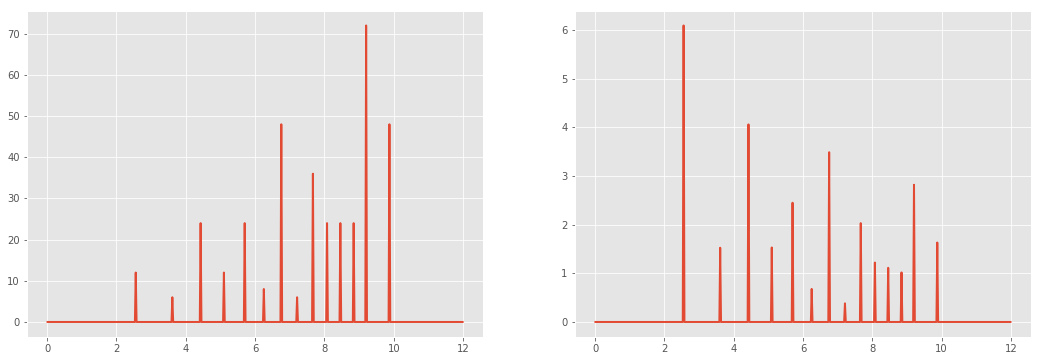

In [12]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(18, 6))
ax[0].plot(bin_centers, rdf)
ax[1].plot(bin_centers, pdf)
plt.show()

### Computation of RDF using neighbor_list taking into account periodicity

In [13]:
atoms = aio.read("data/struct_1.cif").repeat([2,2,2])

In [14]:
sym1 = "H"
sym2 = "C"
syms = np.asarray(atoms.get_chemical_symbols())
idx_1 = np.where(syms == sym1)[0]
idx_2 = np.where(syms == sym2)[0]

coords = atoms.get_positions()
cell = atoms.get_cell()
pbc = atoms.get_pbc()

coords_1 = coords[idx_1]
coords_2 = coords[idx_2]

N_1 = len(idx_1)
N_2 = len(idx_2)

atom_1 = Atoms(positions=coords_1, 
               cell=cell, pbc=pbc, 
               symbols=[sym1]*N_1)

atom_2 = Atoms(positions=coords_2, 
               cell=cell, pbc=pbc, 
               symbols=[sym2]*N_2)

In [16]:
rdf1, bin_edges = compute_rdf(atom_1, cutoff_=10, nbins_=501)
rdf2, bin_edges = compute_rdf(atom_2, cutoff_=10, nbins_=501)

vols = 4 / 3 * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) * 0.5

pdf1 = rdf1 / vols
pdf2 = rdf2 / vols

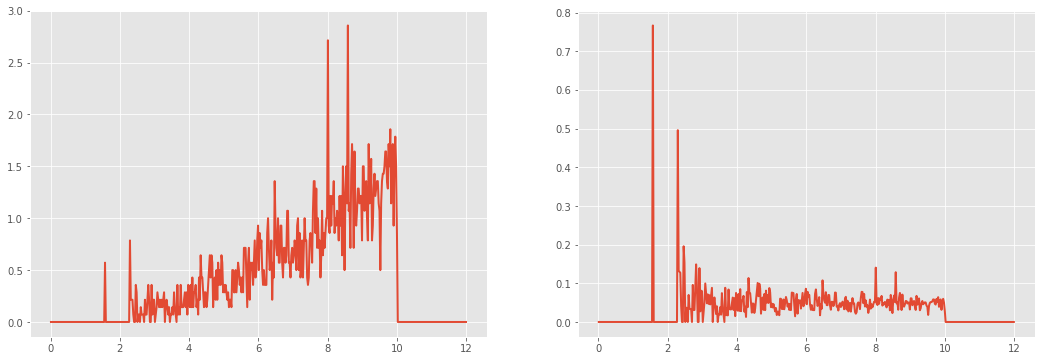

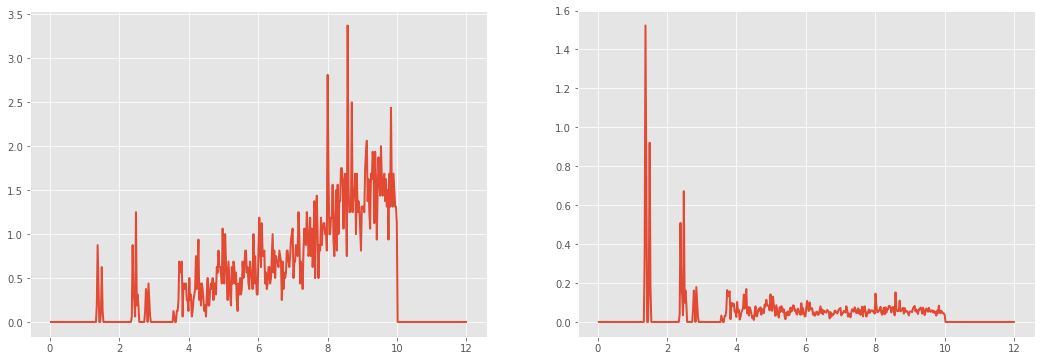

In [17]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(18, 6))
ax[0].plot(bin_centers, rdf1)
ax[1].plot(bin_centers, pdf1)
plt.show()

fig, ax = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(18, 6))
ax[0].plot(bin_centers[1:], rdf2[1:])
ax[1].plot(bin_centers[1:], pdf2[1:])
plt.show()

### Computation of RDF for MFI using neighbor_list taking into account periodicity

In [36]:
%%time
rdf_list, bin_edges = compute_rdf_cross(atoms, cutoff_=10.0, nbins_=501, sym1_=sym1, sym2_=sym2)
vols = 4 / 3 * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) * 0.5

CPU times: user 19.2 s, sys: 2.6 s, total: 21.8 s
Wall time: 19.7 s


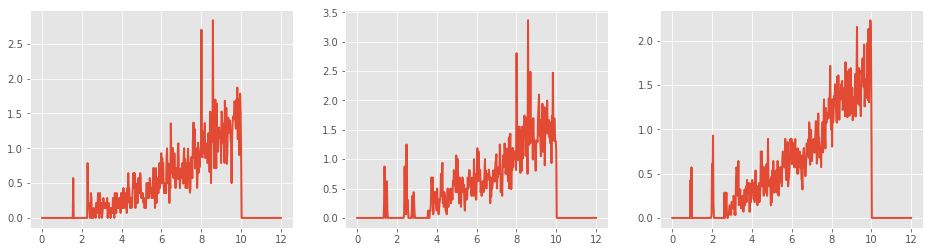

In [35]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=False, figsize=(16, 4))
ax[0].plot(bin_centers, rdf_list[0])
ax[1].plot(bin_centers, rdf_list[1])
ax[2].plot(bin_centers, rdf_list[2])
plt.show()

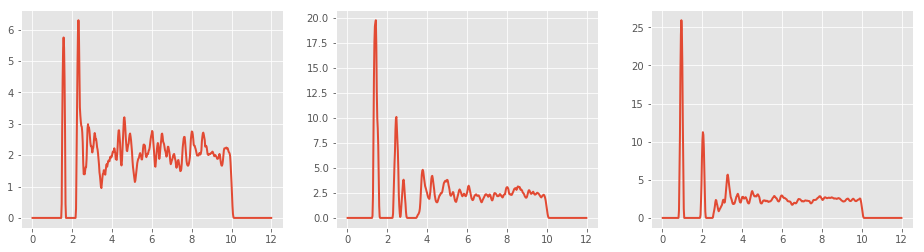

In [41]:
ix = 0
sing_kernel = mk_kernel(width=0.10, x=bin_centers[ix:])

smooth_pdf_C = conv_kernel(sing_kernel, rdf_list[0] / vols[ix:])
smooth_pdf_H = conv_kernel(sing_kernel, rdf_list[1] / vols[ix:])
smooth_pdf_HC = conv_kernel(sing_kernel, rdf_list[2] / vols[ix:])

fig, ax = plt.subplots(1, 3, sharex=True, sharey=False, figsize=(16, 4))
ax[0].plot(bin_centers, smooth_pdf_C)
ax[1].plot(bin_centers, smooth_pdf_H)
ax[2].plot(bin_centers, smooth_pdf_HC)
plt.show()